Dataset link: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T


In [4]:
import pandas as pd
import numpy as np
import tensorflow
import os
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from numpy.random import seed
from tensorflow import set_random_seed
seed(101)
set_random_seed(101)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
os.listdir('../input')

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [7]:
base_dir = 'base_dir' # folder to hold the train, valid, and test folders
os.mkdir(base_dir)

# each of these folders contain each of the 7 classes (in 7 seperate folders)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



### Create Train and Val Sets

In [8]:
df_data = pd.read_csv('../input/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Create a stratified val set

In [9]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [10]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [11]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [12]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [13]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.3, random_state=101, stratify=y)

df_val.shape

(1655, 8)

In [14]:
df_val['dx'].value_counts()

nv       1325
bkl       132
mel        69
bcc        53
akiec      45
vasc       19
df         12
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [15]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8360
1655


In [16]:
df_train['dx'].value_counts()

nv       5380
mel      1044
bkl       967
bcc       461
akiec     282
vasc      123
df        103
Name: dx, dtype: int64

In [17]:
df_val['dx'].value_counts()

nv       1325
bkl       132
mel        69
bcc        53
akiec      45
vasc       19
df         12
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [18]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [19]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/ham10000_images_part_1')
folder_2 = os.listdir('../input/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [20]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5380
1044
967
461
282
123
103


In [21]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

1325
69
132
53
45
19
12


### Copy the train images  into aug_dir

In [22]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1044 images belonging to 1 classes.
Found 967 images belonging to 1 classes.
Found 461 images belonging to 1 classes.
Found 282 images belonging to 1 classes.
Found 123 images belonging to 1 classes.
Found 103 images belonging to 1 classes.


In [23]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5380
6020
5852
5582
5690
4970
4170


In [24]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

1325
69
132
53
45
19
12


### Set Up the Generators

In [27]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [28]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)


test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.


# Create custom MobileNetV2 model

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

In [128]:
def get_mobile():
    mobile = tensorflow.keras.applications.MobileNetV2(input_shape=(image_size, image_size, 3),include_top=False)
    image_batch, label_batch = next(iter(train_batches))
    feature_batch = mobile(image_batch)
    mobile.trainable = False
    global_average_layer = tensorflow.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = Dense(7, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    inputs = tensorflow.keras.Input(shape=(image_size, image_size, 3))
    x = mobile(inputs, training=False)
    x = global_average_layer(x)
    x = tensorflow.keras.layers.Dropout(0.25)(x)
    outputs = prediction_layer(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model, mobile

# Create CNN model

In [51]:
def get_CNN():
    input_shape = (image_size, image_size, 3)
    num_classes = 7

    model = tensorflow.keras.Sequential()
    model.add(tensorflow.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
    model.add(tensorflow.keras.layers.Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
    model.add(tensorflow.keras.layers.MaxPool2D(pool_size = (2, 2)))
    model.add(tensorflow.keras.layers.Dropout(0.25))

    model.add(tensorflow.keras.layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(tensorflow.keras.layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(tensorflow.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tensorflow.keras.layers.Dropout(0.40))

    model.add(tensorflow.keras.layers.Flatten())
    model.add(tensorflow.keras.layers.Dense(128, activation='relu'))
    model.add(tensorflow.keras.layers.Dropout(0.5))
    model.add(tensorflow.keras.layers.Dense(num_classes, activation='softmax'))
    model.summary()
    return model

# Train

In [129]:
from tensorflow.keras.metrics import categorical_accuracy

In [130]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [131]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel is hard to learn, therefore increase the weight
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [132]:
model, mobile = get_mobile() #  fix this accordingly for CNN
model.compile(Adam(lr=0.0001), loss=categorical_crossentropy, 
              metrics=[categorical_accuracy])

In [133]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/15
835/836 [============================>.] - ETA: 0s - loss: 1.6929 - categorical_accuracy: 0.3219
Epoch 00001: val_categorical_accuracy improved from -inf to 0.74260, saving model to model.h5
836/836 [==============================] - 60s 71ms/step - loss: 1.6928 - categorical_accuracy: 0.3220 - val_loss: 0.8732 - val_categorical_accuracy: 0.7426
Epoch 2/15
835/836 [============================>.] - ETA: 0s - loss: 1.2759 - categorical_accuracy: 0.4801
Epoch 00002: val_categorical_accuracy improved from 0.74260 to 0.78912, saving model to model.h5
836/836 [==============================] - 53s 64ms/step - loss: 1.2755 - categorical_accuracy: 0.4801 - val_loss: 0.6509 - val_categorical_accuracy: 0.7891
Epoch 3/15
835/836 [============================>.] - ETA: 0s - loss: 1.1577 - categorical_accuracy: 0.5310
Epoch 00003: val_categorical_accuracy improved from 0.78912 to 0.79335, saving model to model.h5
836/836 [==============================] - 53s 64ms/step - loss: 1.1574 - 

# Evaluate the model using the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [152]:
# Here the the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

val_loss: 0.3252108140405208
val_cat_acc: 0.908761329305136


In [151]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc = model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
# print('val_top_2_acc:', val_top_2_acc)
# print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.3252108140405208
val_cat_acc: 0.908761329305136


# Further Training for MobileNetV2

In [64]:
import matplotlib.pyplot as plt

In [142]:
mobile.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobile.layers[:fine_tune_at]:
  layer.trainable = False

In [143]:
model.compile(Adam(lr=0.0001), loss=categorical_crossentropy, 
              metrics=[categorical_accuracy])

In [144]:
len(model.trainable_variables)

58

In [145]:
fine_tune_epochs = 15
total_epochs =  15 + fine_tune_epochs

history_fine = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=total_epochs,initial_epoch=history.epoch[-1],
                                   verbose=1,
                   callbacks=callbacks_list)

Epoch 15/30
834/836 [============================>.] - ETA: 0s - loss: 0.6924 - categorical_accuracy: 0.7221
Epoch 00015: val_categorical_accuracy improved from 0.85438 to 0.86586, saving model to model.h5
836/836 [==============================] - 66s 80ms/step - loss: 0.6930 - categorical_accuracy: 0.7215 - val_loss: 0.4113 - val_categorical_accuracy: 0.8659
Epoch 16/30
835/836 [============================>.] - ETA: 0s - loss: 0.6253 - categorical_accuracy: 0.7501
Epoch 00016: val_categorical_accuracy improved from 0.86586 to 0.87009, saving model to model.h5
836/836 [==============================] - 55s 65ms/step - loss: 0.6253 - categorical_accuracy: 0.7500 - val_loss: 0.3669 - val_categorical_accuracy: 0.8701
Epoch 17/30
834/836 [============================>.] - ETA: 0s - loss: 0.5822 - categorical_accuracy: 0.7638
Epoch 00017: val_categorical_accuracy improved from 0.87009 to 0.89305, saving model to model.h5
836/836 [==============================] - 55s 66ms/step - loss: 0.5

# Plotting

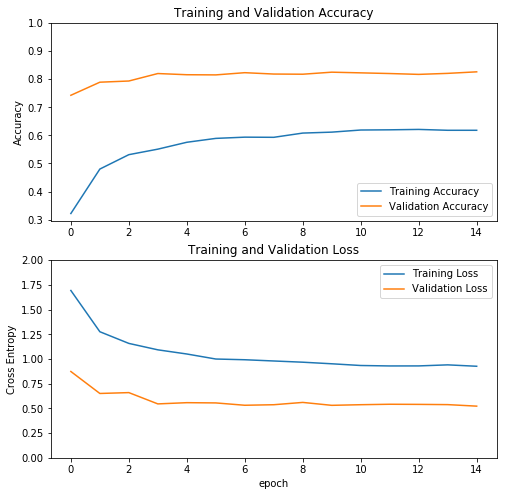

In [ ]:
# For CNN we can use this to plot
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [149]:
# plot for MobileNetV2 only
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

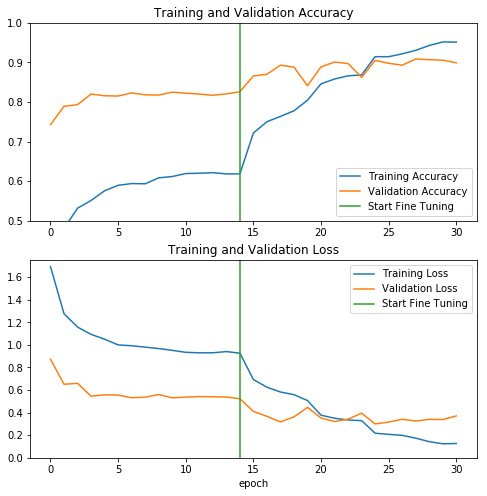

In [150]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([15-1,15-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.750])
plt.plot([15-1,15-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
c
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# The below part is for both

### Create a Confusion Matrix

In [153]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [154]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [155]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [156]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

1655/1655 [==============================] - 24s 14ms/step


In [157]:
predictions.shape

(1655, 7)

In [158]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [159]:
test_labels.shape

(1655,)

In [160]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [161]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  20    6    9    1    7    2    0]
 [   4   43    1    0    1    4    0]
 [   4    1   81    0   17   29    0]
 [   0    0    0    4    1    7    0]
 [   0    1    7    0   46   15    0]
 [   2    1   11    0   18 1293    0]
 [   0    0    0    0    0    2   17]]


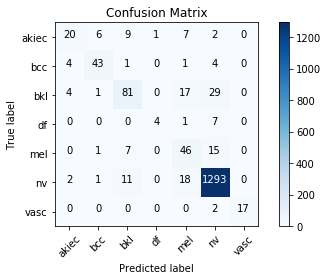

In [162]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [163]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [164]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

             precision    recall  f1-score   support

      akiec       0.67      0.44      0.53        45
        bcc       0.83      0.81      0.82        53
        bkl       0.74      0.61      0.67       132
         df       0.80      0.33      0.47        12
        mel       0.51      0.67      0.58        69
         nv       0.96      0.98      0.97      1325
       vasc       1.00      0.89      0.94        19

avg / total       0.91      0.91      0.91      1655

